# Problem 2 - Sentiment Analysis

## Group 5
> Sujith Nair

> Mahesh. M. Iyer

> My Pham

In [546]:
import pandas as pd
import seaborn as sns
%pylab inline
import requests, re
import pandas as pd
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))


Populating the interactive namespace from numpy and matplotlib


C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table', 'Text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [547]:
#Load business dataset
business = pd.read_csv('yelp_business.csv')
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.3307,-111.9786,4.0000,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.2917,-80.1049,3.0000,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.5249,-112.1153,1.5000,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.3831,-111.9647,3.0000,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [548]:
#NaN values in each column
print(len(business)-business.count())

#Drop columns with too many NaN Values
business.drop(['neighborhood'], axis=1, inplace=True)

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64


In [549]:
## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')
business.head(3)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,33.3307,-111.9786,4.0000,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.2917,-80.1049,3.0000,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,33.5249,-112.1153,1.5000,18,1,Departments of Motor Vehicles;Public Services ...


In [550]:
business.categories.count()
#business[business['categories'].str.contains('Gym')].count()


174567

In [551]:
## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
usa.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,33.3307,-111.9786,4.0000,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.2917,-80.1049,3.0000,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,33.5249,-112.1153,1.5000,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,"5000 Arizona Mills Cr, Ste 435",Tempe,AZ,85282,33.3831,-111.9647,3.0000,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [552]:
## select all restaurants in USA
#us_restaurants=usa[usa['categories'].str.contains('Restaurants')

usa.shape

(128302, 12)

In [553]:
## check whether has duplicated business id
usa.business_id.duplicated().sum()

0

In [554]:
## check the datatype
usa.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
categories       object
dtype: object

In [555]:
## check missing values
usa.isnull().sum()

business_id       0
name              0
address           0
city              0
state             0
postal_code     417
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
categories        0
dtype: int64

In [758]:
from collections import Counter
results = Counter()
usa['categories'].str.split(";").apply(results.update)
category = pd.DataFrame.from_dict(results, orient='index').reset_index()
category = category.rename(columns={'index':'category_type',0:'count'})
category_list = list(category.sort_values(by='count',ascending=False).category_type[category['count']>=1000].unique())
category_list
usa['category1']=pd.Series()
for i in range(0,len(category_list)-1):
    usa.loc[(usa.categories.str.contains(category_list[i]) & usa.category1.isnull()),'category1'] = category_list[i]
len(usa)-usa.count()


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


business_id       0
name              0
address           0
city              0
state             0
postal_code     396
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
categories        0
category1         0
dtype: int64

In [759]:
usa.head()
len(category_list)

92

In [760]:
#Drop NaN values for category1
usa = usa[usa.category1.notnull()]
len(usa)-usa.count()

business_id       0
name              0
address           0
city              0
state             0
postal_code     396
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
categories        0
category1         0
dtype: int64

#Clean Review Dataset



In [761]:
## load review table
#review = pd.read_csv('yelp_review.csv')
review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [762]:
#review=review.head(100000)

In [763]:
## check missing values
review.isnull().sum()



review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [764]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

In [765]:
## merge business table and review table
us_reviews = pd.merge(usa, review, on = 'business_id')



In [766]:
## update column names
us_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)



In [767]:
## add column of number of words in review and label of negative and postive reviews
us_reviews['num_words_review'] = us_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

In [768]:
us_reviews.shape

(82492, 22)

In [769]:
# label reviews as positive or negative
us_reviews['labels'] = ''
us_reviews.loc[us_reviews.review_star >=4, 'labels'] = 'positive'
us_reviews.loc[us_reviews.review_star ==3, 'labels'] = 'neutral'
us_reviews.loc[us_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
us_reviews.drop(us_reviews[us_reviews['labels'] =='neutral'].index, axis=0, inplace=True)
us_reviews.reset_index(drop=True, inplace=True)

us_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,categories,category1,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels
0,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.2917,-80.1049,3.0000,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...,Beauty & Spas,eBzyNuX1JdAXvSuMfY-W3A,g2vEmYXXwCh1325OVWNlIg,1,2016-07-25,I would be grateful to those of you willing t...,6,4,0,56,negative
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,I've always enjoyed my time at brick house foo...,0,0,0,37,positive
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...,0,0,0,60,negative
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0,106,negative
4,OD2hnuuTJI9uotcKycxg1A,Soccer Zone,"7240 W Lake Mead Blvd, Ste 4",Las Vegas,NV,89128,36.1975,-115.2497,1.5000,9,1,Shopping;Sporting Goods,Shopping,KLOiJj012N_EjkDqdLBIvg,93HXRm5ih2TVlSUKbGqJxA,1,2017-07-25,Very disappointed. This location is convenient...,0,0,0,191,negative


##Data exploration

In [770]:
plt.style.use('ggplot')

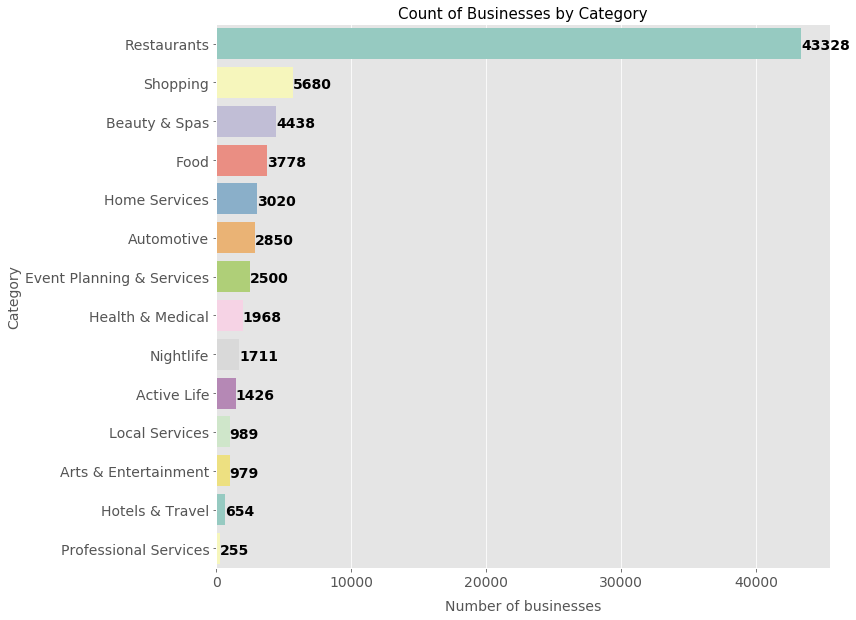

In [771]:
plt.figure(figsize=(11,10))
grouped = us_reviews.category1.value_counts()
sns.countplot(y='category1',data=us_reviews, 
              order = grouped.index, palette= sns.color_palette("Set3", len(grouped)))
plt.xlabel('Number of businesses', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Businesses by Category', fontsize=15)

plt.tick_params(labelsize=14)
for  i, v in enumerate(us_reviews.category1.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

In [772]:
table = pd.pivot_table(us_reviews, values=["review_id"], index=["category1"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

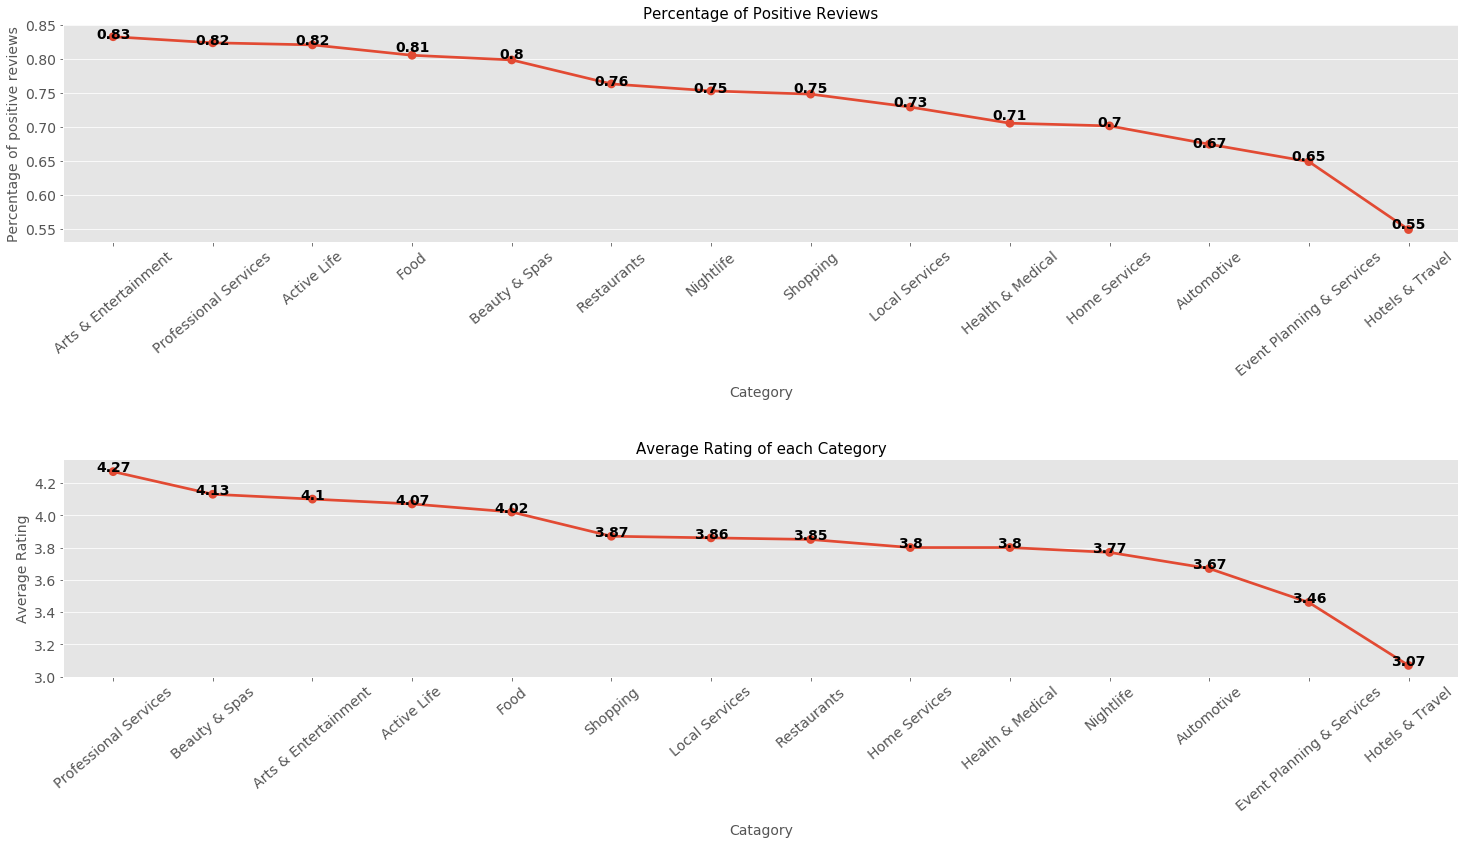

In [773]:
plt.figure(figsize=(25,12))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = us_reviews.groupby('category1')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(grouped.index, grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)


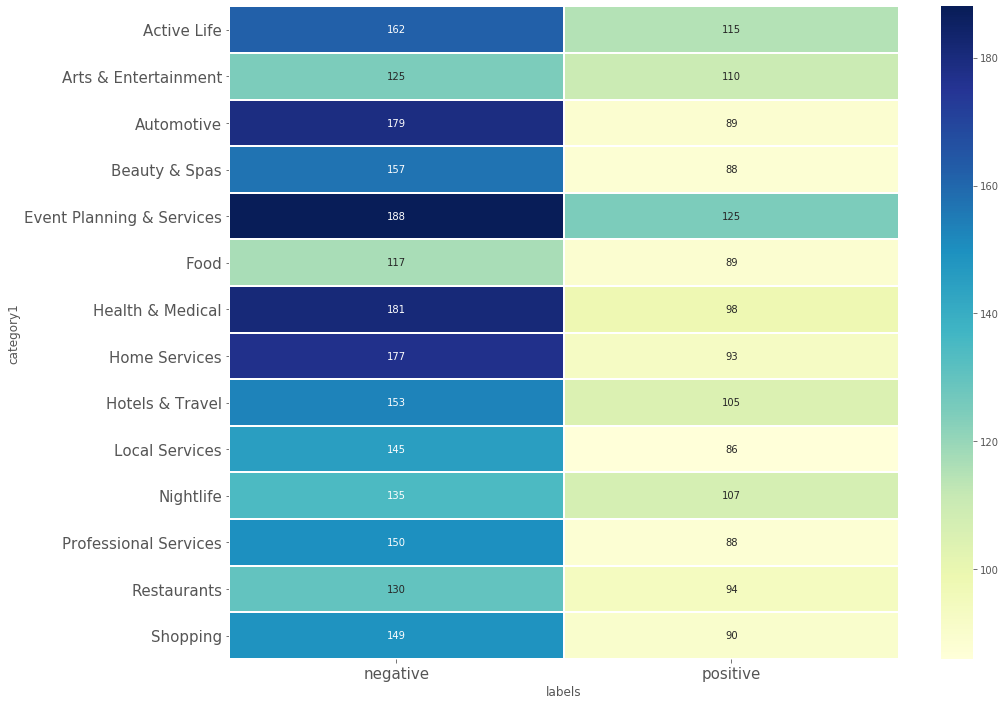

In [774]:
table = us_reviews.groupby(['category1','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(15,12))
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

In [775]:
us_reviews.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'avg_star', 'review_count', 'is_open', 'categories', 'category1', 'review_id', 'user_id', 'review_star', 'date', 'text', 'useful', 'funny', 'cool', 'num_words_review', 'labels'], dtype='object')

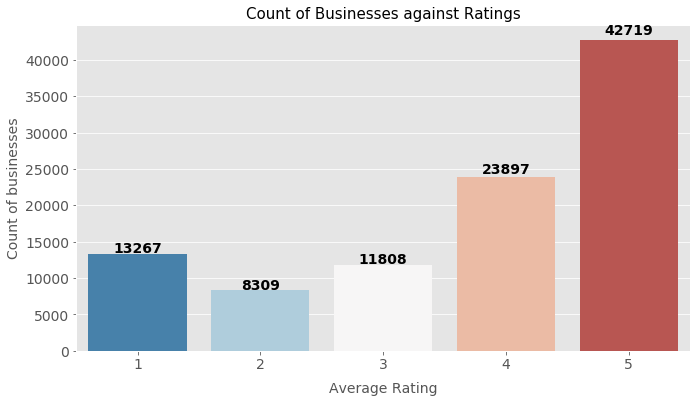

In [776]:
#Review Distribution 
plt.figure(figsize=(11,6))
grouped = review.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of businesses', fontsize=14)
plt.title('Count of Businesses against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)



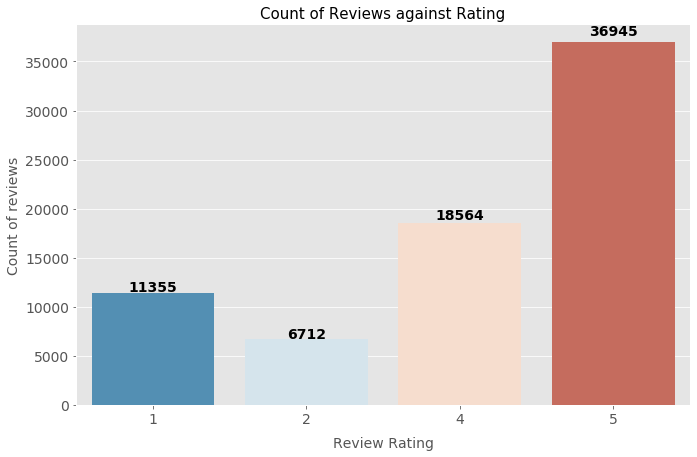

In [777]:
#Dist of ratings by reviews

plt.figure(figsize=(11,7))
grouped = us_reviews.review_star.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)


In [778]:
#Review Analysis
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [779]:
## convert text to lower case
us_reviews.text = us_reviews.text.str.lower()

## remove unnecessary punctuation
us_reviews['removed_punct_text']= us_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

In [780]:
us_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,categories,category1,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels,removed_punct_text
0,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.2917,-80.1049,3.0000,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...,Beauty & Spas,eBzyNuX1JdAXvSuMfY-W3A,g2vEmYXXwCh1325OVWNlIg,1,2016-07-25,i would be grateful to those of you willing t...,6,4,0,56,negative,i would be grateful to those of you willing t...
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,i've always enjoyed my time at brick house foo...,0,0,0,37,positive,i've always enjoyed my time at brick house foo...
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. came w my unc bc louies was clo...,0,0,0,60,negative,1st time here came w my unc bc louies was clos...
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,Restaurants,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,worse service ever andi use to be a server so ...,0,0,0,106,negative,worse service ever andi use to be a server so ...
4,OD2hnuuTJI9uotcKycxg1A,Soccer Zone,"7240 W Lake Mead Blvd, Ste 4",Las Vegas,NV,89128,36.1975,-115.2497,1.5000,9,1,Shopping;Sporting Goods,Shopping,KLOiJj012N_EjkDqdLBIvg,93HXRm5ih2TVlSUKbGqJxA,1,2017-07-25,very disappointed. this location is convenient...,0,0,0,191,negative,very disappointed this location is convenient ...


In [781]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [782]:
## get dataset by category
def get_dataset(category1):
    df = us_reviews[['removed_punct_text','labels']][us_reviews.category1==category1]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    try:
        words = [word for word in review.split() if not word in positive_words + negative_words]
        words = ' '.join(words)
        return words
    except KeyError:
        pass
    
# remove stop words
def filter_stopwords(review):
    words = [word for word in review.split() if not word in stop_words]
    words = ' '.join(words)
    return words



In [783]:
#Using 'Food' as an example

category1_review = get_dataset('Food')

In [784]:
category1_train, category1_test = train_test_split(category1_review[['text','labels']],test_size=0.5)
print('Total %d number of reviews' % category1_train.shape[0])



Total 1889 number of reviews


In [785]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [786]:
## filter words
category1_train.text = category1_train.text.apply(filter_words)


In [787]:
category1_train.head()

,text,labels
3667,the grocery is a great addition to ohio city i...,positive
424,long delayed review here clearly there is no s...,positive
1135,straight up i am not typically a donut person ...,negative
1683,this little brewery is a gem the beer is reall...,positive
1107,when i think of heinen's of bainbridge i can't...,positive


In [788]:
category1_train.text = category1_train.text.apply(filter_stopwords)

In [789]:
## construct features and labels
terms_train=list(category1_train['text'])
class_train=list(category1_train['labels'])

terms_test=list(category1_test['text'])
class_test=list(category1_test['labels'])



In [790]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(1889, 11831)

In [791]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [792]:
## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
category1_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

In [793]:
## get frequency of each word in all reviews in specific category
category1_review = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())


In [794]:
category1_review['labels'] = class_train


In [795]:
category1_frequency = category1_review[category1_review['labels'] =='positive'].sum()[:-1]


In [796]:
category1_score.set_index('word', inplace=True)

In [797]:
category1_polarity_score = category1_score

category1_polarity_score['frequency'] = category1_frequency


In [798]:
category1_polarity_score['frequency'] = pd.to_numeric(category1_polarity_score.frequency, errors='coerce')

In [799]:
category1_polarity_score.dtypes

score        float64
frequency    float64
dtype: object

In [800]:
## calculate polarity score 
category1_polarity_score['polarity'] = category1_polarity_score.score * category1_polarity_score.frequency/category1_review.shape[0]

In [801]:
## drop unnecessary words
unuseful_positive_words = category1_polarity_score.loc[['really','back','find','plus','see','guys','thank','need','also','thanks','work','highly','day','little','way','make','everything','first','able','great','amazing','love','best','awesome','excellent','good','favorite','loved','perfect','gem','perfectly','wonderful','happy','enjoyed','nice','well','super','like','better','decent','fine','pretty','enough','excited','impressed','ready','fantastic','glad','right','fabulous','definitely','think','nicely']]
unuseful_negative_words =  category1_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible','lacking','terrible','sorry', 'disappoint','awful']]

category1_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
category1_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [802]:
category1_polarity_score.polarity = category1_polarity_score.polarity.astype(float)
category1_polarity_score.frequency = category1_polarity_score.frequency.astype(float)

In [1]:
category1_polarity_score[category1_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

NameError: name 'category1_polarity_score' is not defined

In [804]:
category1_polarity_score.reset_index(level=0,inplace=True)
category1_polarity_score.columns

Index(['word', 'score', 'frequency', 'polarity'], dtype='object')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


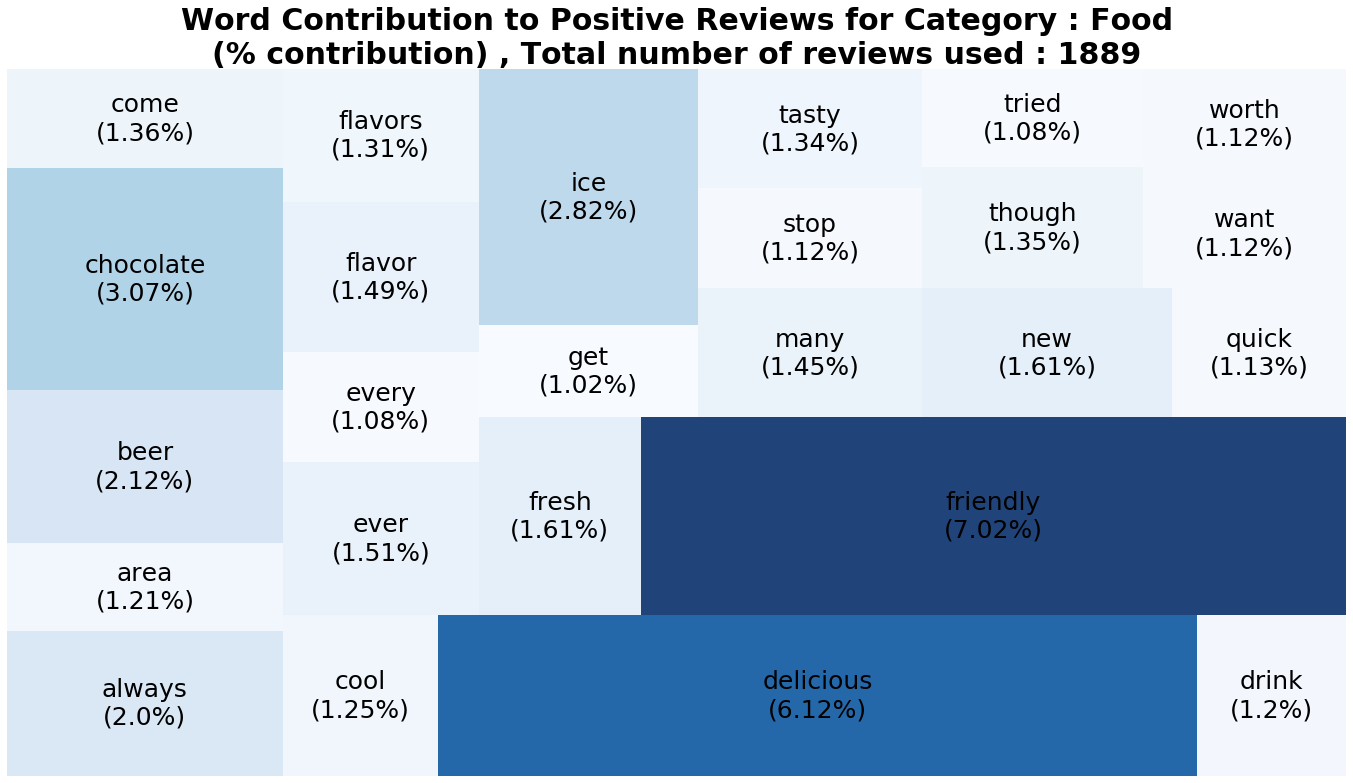

In [805]:
import squarify
# New dataframe, containing only players with more than 0 goals.
dataGoals = category1_polarity_score[category1_polarity_score["polarity"]>0.01]
dataGoals['new']= dataGoals.word + '\n(' + (dataGoals.polarity*100).round(2).apply(str)+'%)'


#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(dataGoals.polarity), vmax=max(dataGoals.polarity))
colors = [matplotlib.cm.Blues(norm(value)) for value in dataGoals.polarity]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(24, 13)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=dataGoals.new,sizes=dataGoals.polarity, color = colors, alpha=.9,text_kwargs={'fontsize':25})
plt.title("Word Contribution to Positive Reviews for Category : Food"+"\n(% contribution) , Total number of reviews used : 1889",fontsize=30,fontweight="bold")
#Remove our axes and display the plot
plt.axis('off')
plt.show()